In [222]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from pyfixest.estimation import feols
from pyfixest.utils import get_data



In [223]:
#import txt data
exp= pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW5/data/output/medicaid_expansion.txt', sep='\t')

medicaid= pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW5/data/output/acs_medicaid.txt', sep='\t')

insurance= pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW5/data/output/acs_insurance.txt', sep='\t')


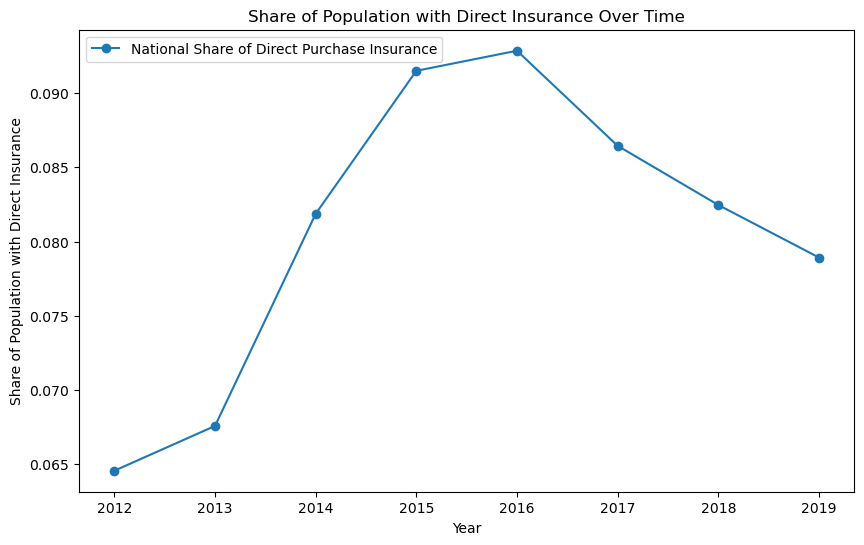

In [224]:
#Q1
# groupby year and sum adult pop and ins_direct for each state 
Nat_share = insurance.groupby('year')[['ins_direct', 'adult_pop']].sum()
Nat_share['Nat_dir_share'] = Nat_share['ins_direct'] / Nat_share['adult_pop']

# Plotting the national share of direct purchase insurance
plt.figure(figsize=(10, 6))
plt.plot(Nat_share.index, Nat_share['Nat_dir_share'], marker='o', label='National Share of Direct Purchase Insurance')
plt.title('Share of Population with Direct Insurance Over Time')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Share of Population with Direct Insurance')
plt.show()


# Q2


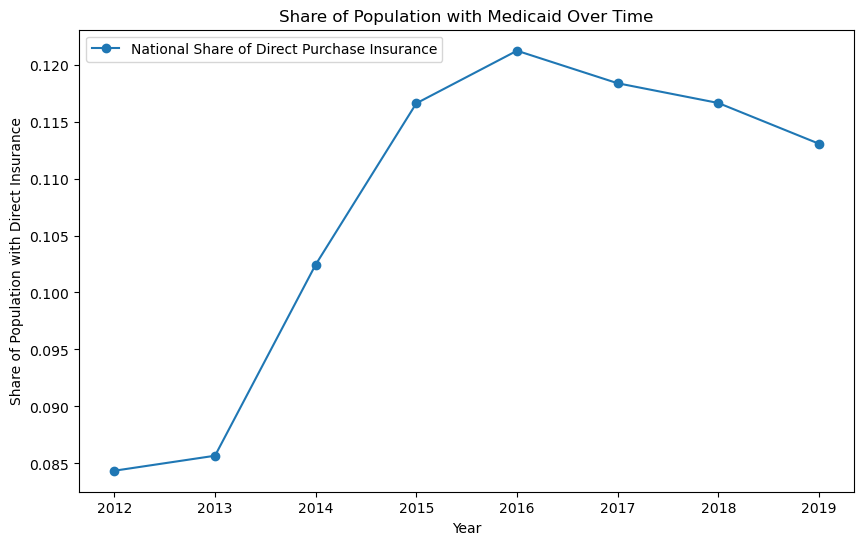

In [225]:
#Q3
# groupby year and sum adult pop and ins_direct for each state 
Nat_share_MA = medicaid.groupby('year')[['ins_medicaid', 'adult_pop']].sum()
Nat_share_MA['Nat_dir_share'] = Nat_share_MA['ins_medicaid'] / Nat_share_MA['adult_pop']

# Plotting the national share of direct purchase insurance
plt.figure(figsize=(10, 6))
plt.plot(Nat_share_MA.index, Nat_share_MA['Nat_dir_share'], marker='o', label='National Share of Direct Purchase Insurance')
plt.title('Share of Population with Medicaid Over Time')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Share of Population with Direct Insurance')
plt.show()



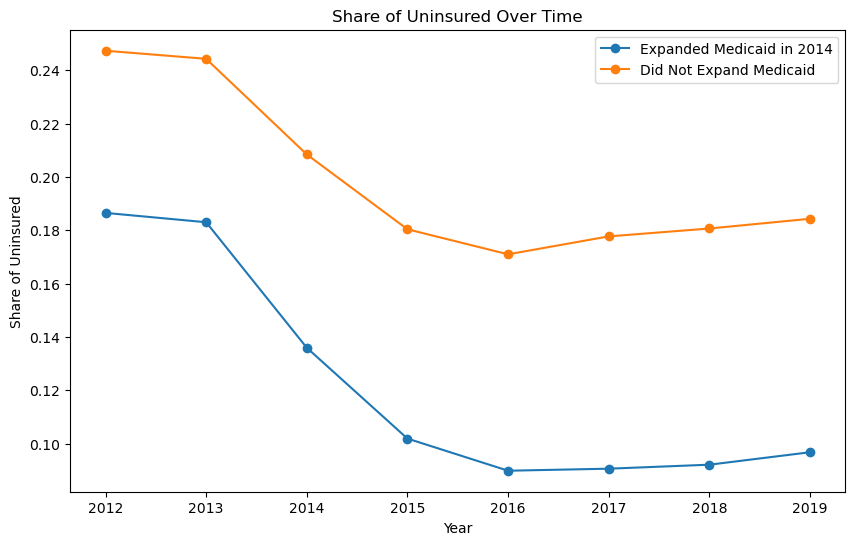

In [226]:
#Q4
#Drop all states that expanded after 2014.
# Ensure 'date_adopted' is in datetime format
exp['date_adopted'] = pd.to_datetime(exp['date_adopted'])

# Keep only rows where expansion was in 2014 or earlier
exp_2014 = exp[exp['date_adopted'].dt.year <= 2014]
states_exp_2014 = exp_2014['State'].unique().tolist()
non_exp_states = exp[exp['expanded'] == False]
non_exp_state_list = non_exp_states['State'].unique().tolist()
#Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not. 


insurance_expanded = insurance[insurance['State'].isin(states_exp_2014)]
exp_share_uninsured = insurance_expanded.groupby('year')[['uninsured', 'adult_pop']].sum()
exp_share_uninsured['uninsured_share'] = exp_share_uninsured['uninsured'] / exp_share_uninsured['adult_pop']

insurance_nonexpanded = insurance[insurance['State'].isin(non_exp_state_list)]
nonexp_share_uninsured = insurance_nonexpanded.groupby('year')[['uninsured', 'adult_pop']].sum()
nonexp_share_uninsured['uninsured_share'] = nonexp_share_uninsured['uninsured'] / nonexp_share_uninsured['adult_pop']

# plot both together on same figure
plt.figure(figsize=(10, 6))
plt.plot(exp_share_uninsured.index, exp_share_uninsured['uninsured_share'], marker='o', label='Expanded Medicaid in 2014')
plt.plot(nonexp_share_uninsured.index, nonexp_share_uninsured['uninsured_share'], marker='o', label='Did Not Expand Medicaid')
plt.title('Share of Uninsured Over Time')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Share of Uninsured')
plt.show()

In [227]:
#Q5

exp_filtered = exp_share_uninsured.loc[[2012, 2015], 'uninsured_share']
nonexp_filtered = nonexp_share_uninsured.loc[[2012, 2015], 'uninsured_share']

# DD 2x2 table
dd_table = pd.DataFrame({
    'Expansion States': exp_filtered,
    'Non-Expansion States': nonexp_filtered
})

dd_table.index.name = 'Year'
print(dd_table)

      Expansion States  Non-Expansion States
Year                                        
2012          0.186524              0.247324
2015          0.101914              0.180381


In [228]:

# Step 1: Add treatment flag and stack data
exp2 = exp_share_uninsured[['uninsured', 'adult_pop']].copy()
exp2['group'] = 1  # Treated group
exp2['year'] = exp2.index

nonexp = nonexp_share_uninsured[['uninsured', 'adult_pop']].copy()
nonexp['group'] = 0  # Control group
nonexp['year'] = nonexp.index

# Step 2: Combine into one DataFrame
reg_df = pd.concat([exp2, nonexp], ignore_index=True)

# Step 3: Create DD variables
reg_df['post'] = (reg_df['year'] > 2013).astype(int)
reg_df['interaction'] = reg_df['group'] * reg_df['post']
reg_df['uninsured_share'] = reg_df['uninsured'] / reg_df['adult_pop']

# Step 4: Run DD regression
model = smf.ols("uninsured_share ~ group + post + interaction", data=reg_df).fit()

# Step 5: View results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        uninsured_share   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     67.02
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           9.13e-08
Time:                        16:59:20   Log-Likelihood:                 47.766
No. Observations:                  16   AIC:                            -87.53
Df Residuals:                      12   BIC:                            -84.44
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2458      0.010     24.626      

/Users/ryanscholte/anaconda3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [229]:

exp['date_adopted'] = pd.to_datetime(exp['date_adopted'])
# add year column and adjust date_adopted to year
exp['year'] = exp['date_adopted'].dt.year
print(exp.head())


        State  expanded date_adopted    year
0     Alabama     False          NaT     NaN
1      Alaska      True   2015-09-01  2015.0
2     Arizona      True   2014-01-01  2014.0
3    Arkansas      True   2014-01-01  2014.0
4  California      True   2014-01-01  2014.0


In [230]:
insurance_merged = insurance.merge(
    exp[['State', 'year', 'expanded']], 
    on=['State', 'year'], how='left'
)

expand_years = exp[exp['expanded'] == True].groupby('State')['year'].min().reset_index()
expand_years.columns = ['State', 'expand_year']

insurance_merged = insurance_merged.merge(expand_years, on='State', how='left')

df = insurance_merged[
    (insurance_merged['expand_year'] == 2014) | (insurance_merged['expand_year'].isna())
].copy()

df['treated'] = (df['expand_year'] == 2014).astype(int)
df['post'] = (df['year'] >= 2014).astype(int)
df['interaction'] = df['treated'] * df['post']
df['perc_unins'] = df['uninsured'] / df['adult_pop']

model = feols(
    fml='perc_unins ~ interaction | State + year',
    data=df,
    vcov={'CRV1': 'State'}
)

print(model.summary())

###

Estimation:  OLS
Dep. var.: perc_unins, Fixed effects: State+year
Inference:  CRV1
Observations:  360

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| interaction   |     -0.022 |        0.008 |    -2.909 |      0.006 | -0.037 |  -0.007 |
---
RMSE: 0.013 R2: 0.947 R2 Within: 0.109 
None


In [231]:
insurance_merged = insurance.merge(
    exp[['State', 'year', 'expanded']], 
    on=['State', 'year'], how='left'
)

expand_years = exp[exp['expanded'] == True].groupby('State')['year'].min().reset_index()
expand_years.columns = ['State', 'expand_year']

insurance_merged = insurance_merged.merge(expand_years, on='State', how='left')

# all** states — no filtering

df_all = insurance_merged.copy()

df_all['treated'] = (df_all['expand_year'] == 2014).astype(int)
df_all['post'] = (df_all['year'] >= 2014).astype(int)
df_all['interaction'] = df_all['treated'] * df_all['post']
df_all['perc_unins'] = df_all['uninsured'] / df_all['adult_pop']

model_all = feols(
    fml='perc_unins ~ interaction | State + year',
    data=df_all,
    vcov={'CRV1': 'State'}
)

print(model_all.summary())

###

Estimation:  OLS
Dep. var.: perc_unins, Fixed effects: State+year
Inference:  CRV1
Observations:  416

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| interaction   |     -0.018 |        0.007 |    -2.398 |      0.020 | -0.032 |  -0.003 |
---
RMSE: 0.014 R2: 0.941 R2 Within: 0.072 
None


In [232]:
#9
#10
